# 预训练BERT
:label:`sec_bert-pretraining`

利用 :numref:`sec_bert`中实现的BERT模型和 :numref:`sec_bert-dataset`中从WikiText-2数据集生成的预训练样本，我们将在本节中在WikiText-2数据集上对BERT进行预训练。


In [1]:
import sys
sys.path.append("..")

In [2]:
import mindspore
import mindspore.nn as nn
from d2l import mindspore as d2l

首先，我们加载WikiText-2数据集作为小批量的预训练样本，用于遮蔽语言模型和下一句预测。批量大小是512，BERT输入序列的最大长度是64。注意，在原始BERT模型中，最大长度是512。


In [3]:
batch_size, max_len = 512, 64
train_dataset, vocab = d2l.load_data_wiki(batch_size, max_len)

## 预训练BERT

原始BERT :cite:`Devlin.Chang.Lee.ea.2018`有两个不同模型尺寸的版本。基本模型（$\text{BERT}_{\text{BASE}}$）使用12层（Transformer编码器块），768个隐藏单元（隐藏大小）和12个自注意头。大模型（$\text{BERT}_{\text{LARGE}}$）使用24层，1024个隐藏单元和16个自注意头。值得注意的是，前者有1.1亿个参数，后者有3.4亿个参数。为了便于演示，我们定义了一个小的BERT，使用了2层、128个隐藏单元和2个自注意头。


In [4]:
net = d2l.BERTModel(len(vocab), num_hiddens=128, norm_shape=[128],
                    ffn_num_input=128, ffn_num_hiddens=256, num_heads=2,
                    num_layers=2, dropout=0.2, key_size=128, query_size=128,
                    value_size=128, hid_in_features=128, mlm_in_features=128,
                    nsp_in_features=128)
loss = nn.CrossEntropyLoss()

在定义训练代码实现之前，我们定义了一个辅助函数`_get_batch_loss_bert`。给定训练样本，该函数计算遮蔽语言模型和下一句子预测任务的损失。请注意，BERT预训练的最终损失是遮蔽语言模型损失和下一句预测损失的和。


In [14]:
#@save
def _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                         segments_X, valid_lens_x,
                         pred_positions_X, mlm_weights_X,
                         mlm_Y, nsp_y):
    # 前向传播
    _, mlm_Y_hat, nsp_Y_hat = net(tokens_X, segments_X,
                                  valid_lens_x.reshape(-1),
                                  pred_positions_X)
    # 计算遮蔽语言模型损失
    # mlm_Y_hat = mlm_Y_hat.astype("")
    mlm_Y = mlm_Y.astype("int32")
    mlm_l = loss(mlm_Y_hat.reshape(-1, vocab_size), mlm_Y.reshape(-1)) *\
    mlm_weights_X.reshape(-1, 1)
    mlm_l = mlm_l.sum() / (mlm_weights_X.sum() + 1e-8)
    # 计算下一句子预测任务的损失
    nsp_y = nsp_y.astype("int32")
    nsp_l = loss(nsp_Y_hat, nsp_y)
    l = mlm_l + nsp_l
    return mlm_l, nsp_l, l

通过调用上述两个辅助函数，下面的`train_bert`函数定义了在WikiText-2（`train_dataset`）数据集上预训练BERT（`net`）的过程。训练BERT可能需要很长时间。以下函数的输入`num_steps`指定了训练的迭代步数，而不是像`train_ch13`函数那样指定训练的轮数（参见 :numref:`sec_image_augmentation`）。


In [15]:
def train_bert(train_dataset, net, loss, vocab_size, num_steps):
    trainer = nn.Adam(net.trainable_params(), lr=0.01)
    step, timer = 0, d2l.Timer()
    animator = d2l.Animator(xlabel='step', ylabel='loss',
                            xlim=[1, num_steps], legend=['mlm', 'nsp'])
    # 遮蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric = d2l.Accumulator(4)
    num_steps_reached = False
    def forward_fn(vocab_size, tokens_X, segments_X, valid_lens_x,
                   pred_positions_X, mlm_weights_X, mlm_Y, nsp_y):
        mlm_l, nsp_l, l = _get_batch_loss_bert(net, loss, vocab_size, tokens_X,
                                               segments_X, valid_lens_x,
                                               pred_positions_X, mlm_weights_X,
                                               mlm_Y, nsp_y)
        return mlm_l, nsp_l, l
    grad_fn = mindspore.value_and_grad(forward_fn, None, weights=net.trainable_params(), has_aux=True)
    while step < num_steps and not num_steps_reached:
        net.set_train()
        for tokens_X, segments_X, valid_lens_x, pred_positions_X,\
            mlm_weights_X, mlm_Y, nsp_y in train_dataset.create_tuple_iterator():
                (mlm_l, nsp_l, l), grads = grad_fn(
                    vocab_size, tokens_X, segments_X, valid_lens_x,
                    pred_positions_X, mlm_weights_X, mlm_Y, nsp_y)
                trainer(grads)
                metric.add(mlm_l, nsp_l, tokens_X.shape[0], 1)
                timer.stop()
                animator.add(step + 1,
                             (metric[0] / metric[3], metric[1] / metric[3]))
                step += 1
                if step == num_steps:
                    num_steps_reached = True
                    break

    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on ')

在预训练过程中，我们可以绘制出遮蔽语言模型损失和下一句预测损失。


MLM loss 6.965, NSP loss 0.693
5.1 sentence pairs/sec on 


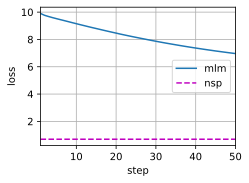

In [16]:
train_bert(train_dataset, net, loss, len(vocab), 50)

## 用BERT表示文本

在预训练BERT之后，我们可以用它来表示单个文本、文本对或其中的任何词元。下面的函数返回`tokens_a`和`tokens_b`中所有词元的BERT（`net`）表示。


In [17]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = mindspore.Tensor(vocab[tokens]).unsqueeze(0)
    segments = mindspore.Tensor(segments).unsqueeze(0)
    valid_len = mindspore.Tensor(len(tokens)).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

考虑“a crane is flying”这句话。回想一下 :numref:`subsec_bert_input_rep`中讨论的BERT的输入表示。插入特殊标记“&lt;cls&gt;”（用于分类）和“&lt;sep&gt;”（用于分隔）后，BERT输入序列的长度为6。因为零是“&lt;cls&gt;”词元，`encoded_text[:, 0, :]`是整个输入语句的BERT表示。为了评估一词多义词元“crane”，我们还打印出了该词元的BERT表示的前三个元素。


In [19]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

((1, 6, 128),
 (1, 128),
 Tensor(shape=[3], dtype=Float32, value= [ 6.56541109e-01,  6.58173203e-01, -8.10980141e-01]))

现在考虑一个句子“a crane driver came”和“he just left”。类似地，`encoded_pair[:, 0, :]`是来自预训练BERT的整个句子对的编码结果。注意，多义词元“crane”的前三个元素与上下文不同时的元素不同。这支持了BERT表示是上下文敏感的。


In [25]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

((1, 10, 128),
 (1, 128),
 Tensor(shape=[3], dtype=Float32, value= [ 6.22545660e-01,  7.01572299e-01, -8.67336214e-01]))